In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# HR Dataset


In [2]:
data = pd.read_csv('HR_Analytics.csv')

In [3]:
data.head()

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,3,80,0,0,2,3,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,1,80,0,0,2,3,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,4,80,0,0,3,3,0,0,0,0.0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,4,80,0,0,2,3,0,0,0,0.0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,4,80,0,0,0,3,0,0,0,0.0


interval columns not set, guessing: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


D:\Archivos de Programa\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable EmpID is large: 1470. Are you sure this is not an interval variable? Analysis for pairs of variables including EmpID can be slow.
  warnings.warn(
D:\Archivos de Programa\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable EmployeeCount for analysis 1. Dropping this column
  warnings.warn(
D:\Archivos de Programa\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable StandardHours for analysis 1. Dropping this column
  warnings.warn(
D:\Archivos de Programa\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable Over18 for analysis 1. Dropping this column
  warnings.warn(


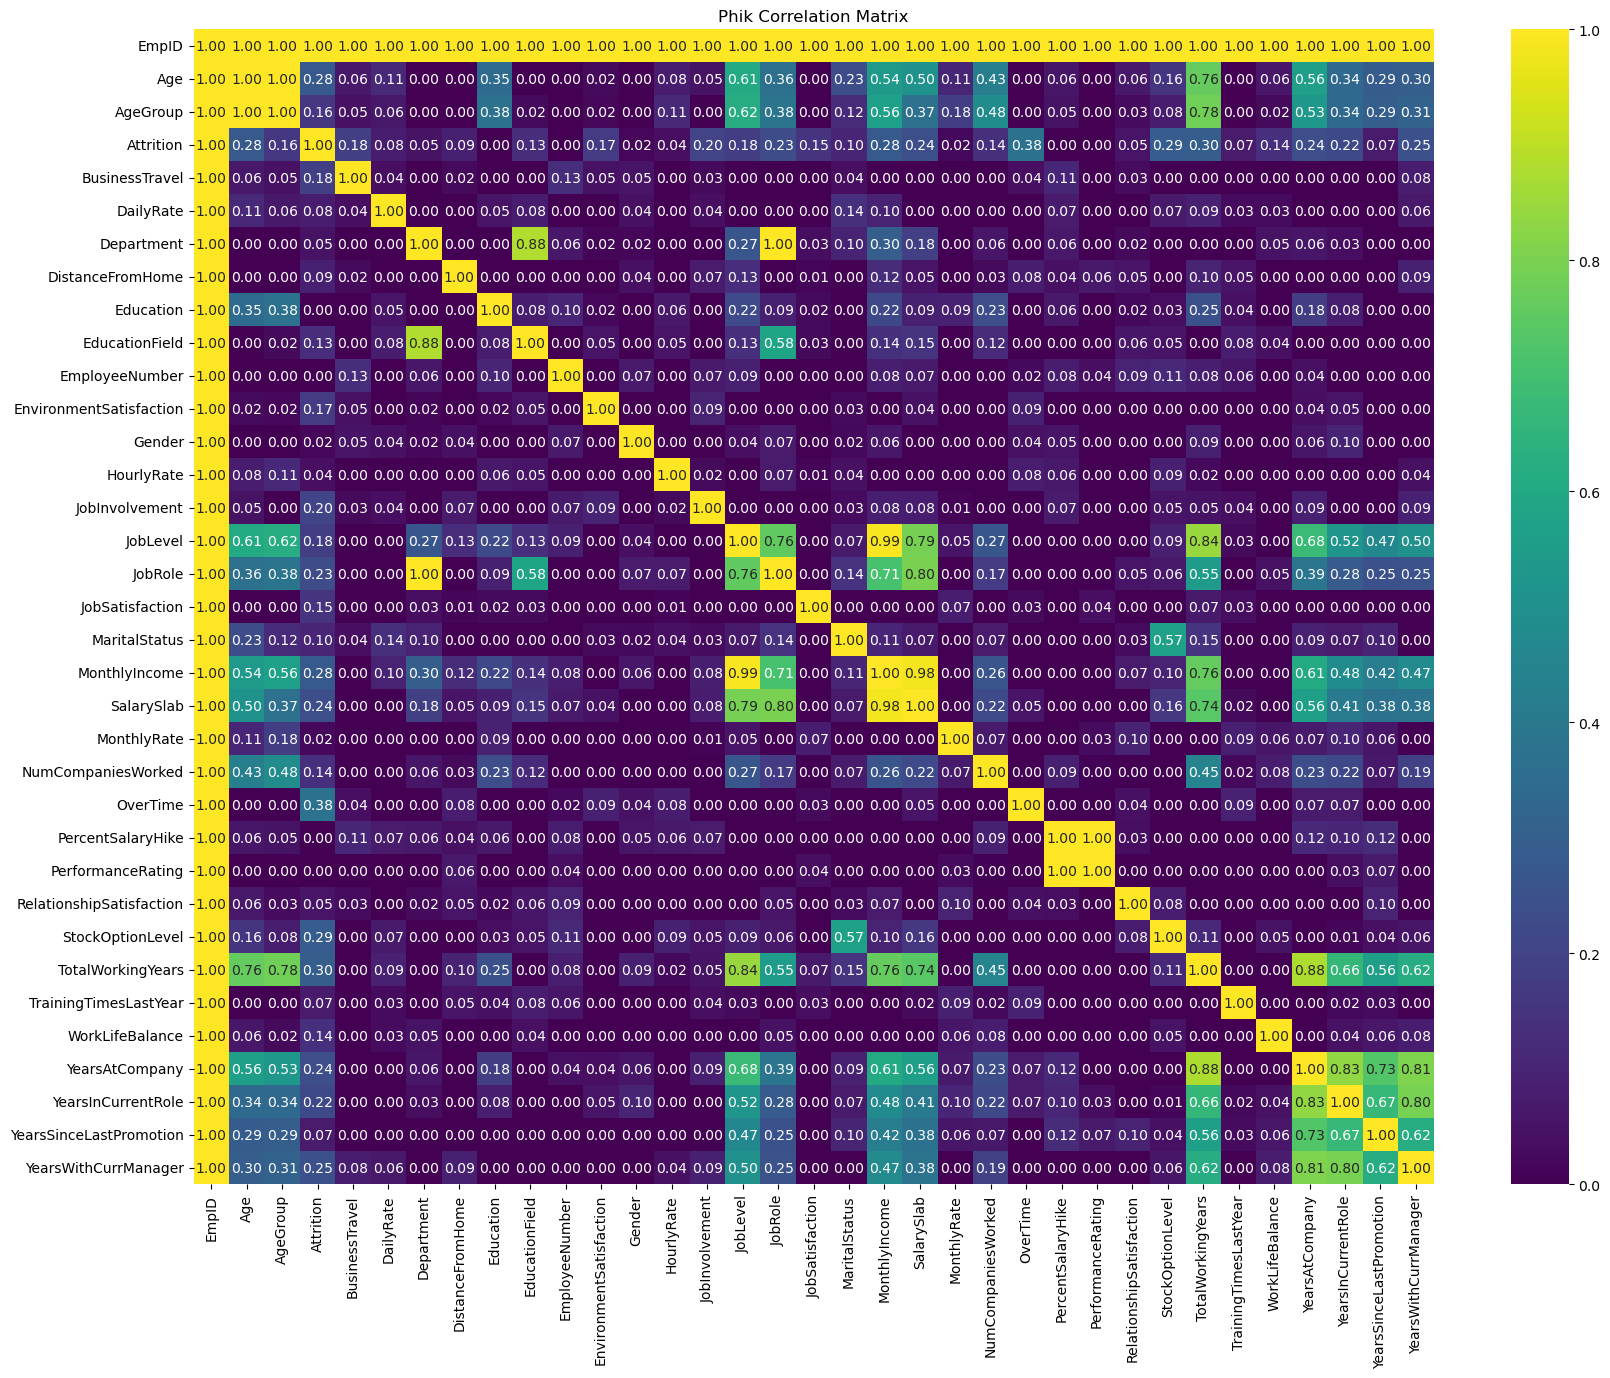

In [3]:
import phik
import seaborn as sns
import matplotlib.pyplot as plt
from phik import resources, report

phik_matrix = data.phik_matrix()

plt.figure(figsize=(20, 15))

sns.heatmap(phik_matrix, annot=True, cmap='viridis', fmt=".2f")

plt.title('Phik Correlation Matrix')

plt.show()

In [29]:
unique_values = data['Column'].unique()
print("Unique values in 'Column Name':", unique_values)

KeyError: 'Column'

# Correlations

The following are the only correlations above 0.98seen, those `highlighted` are therefore dropped

- `age` & age group = 0.910
- salary slab & `monthly income` = 0.933
- `percent salary hike` & performance rating = 0.997
- `department` & job role = 0.937

In [4]:
X = data.drop(['EmpID', 'Attrition', 'EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber', 'Age', 'MonthlyIncome', 'PercentSalaryHike', 'Department'], axis=1)

In [5]:
y = data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

In [6]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

In [7]:
categorical_cols

Index(['AgeGroup', 'BusinessTravel', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'SalarySlab', 'OverTime'],
      dtype='object')

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AgeGroup                  1480 non-null   object 
 1   BusinessTravel            1480 non-null   object 
 2   DailyRate                 1480 non-null   int64  
 3   DistanceFromHome          1480 non-null   int64  
 4   Education                 1480 non-null   int64  
 5   EducationField            1480 non-null   object 
 6   EnvironmentSatisfaction   1480 non-null   int64  
 7   Gender                    1480 non-null   object 
 8   HourlyRate                1480 non-null   int64  
 9   JobInvolvement            1480 non-null   int64  
 10  JobLevel                  1480 non-null   int64  
 11  JobRole                   1480 non-null   object 
 12  JobSatisfaction           1480 non-null   int64  
 13  MaritalStatus             1480 non-null   object 
 14  SalarySl

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [30]:
unique_age_groups = data['AgeGroup'].unique()
unique_business_travel = data['BusinessTravel'].unique()
unique_education_field = data['EducationField'].unique()
unique_gender = data['Gender'].unique()
unique_job_role = data['JobRole'].unique()
unique_marital_status = data['MaritalStatus'].unique()
unique_salary_slab = data['SalarySlab'].unique()
unique_over_time = data['OverTime'].unique()

# Print them to verify
print("Unique Age Groups:", unique_age_groups)
print("Unique Business Travel Options:", unique_business_travel)
print("Unique Education Fields:", unique_education_field)
print("Unique Genders:", unique_gender)
print("Unique Job Roles:", unique_job_role)
print("Unique Marital Statuses:", unique_marital_status)
print("Unique Salary Slabs:", unique_salary_slab)
print("Unique Over Time Options:", unique_over_time)

Unique Age Groups: ['18-25' '26-35' '36-45' '46-55' '55+']
Unique Business Travel Options: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel' 'TravelRarely']
Unique Education Fields: ['Life Sciences' 'Medical' 'Marketing' 'Technical Degree' 'Other'
 'Human Resources']
Unique Genders: ['Male' 'Female']
Unique Job Roles: ['Laboratory Technician' 'Sales Representative' 'Research Scientist'
 'Human Resources' 'Manufacturing Director' 'Sales Executive'
 'Healthcare Representative' 'Research Director' 'Manager']
Unique Marital Statuses: ['Single' 'Divorced' 'Married']
Unique Salary Slabs: ['Upto 5k' '5k-10k' '10k-15k' '15k+']
Unique Over Time Options: ['No' 'Yes']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# KNN Model

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [14]:
y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

KNN Accuracy: 0.8344594594594594
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       249
           1       0.45      0.19      0.27        47

    accuracy                           0.83       296
   macro avg       0.66      0.57      0.59       296
weighted avg       0.80      0.83      0.81       296

Confusion Matrix:
[[238  11]
 [ 38   9]]


In [15]:
parameters = {'n_neighbors':range(1, 51)}

In [16]:
grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parameters,
                           scoring = 'accuracy')

In [17]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51)}, scoring='accuracy')

In [18]:
grid_search.best_params_

{'n_neighbors': 6}

In [19]:
knn_model = grid_search.best_estimator_

In [20]:
grid_search.best_score_

0.8445934348852179

In [21]:
y_pred_knn = knn_model.predict(X_test)
y_pred_knn.shape

(296,)

In [22]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

KNN Accuracy: 0.8581081081081081
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       249
           1       0.86      0.13      0.22        47

    accuracy                           0.86       296
   macro avg       0.86      0.56      0.57       296
weighted avg       0.86      0.86      0.81       296

Confusion Matrix:
[[248   1]
 [ 41   6]]


In [25]:
import joblib

# Save the model to a file
joblib.dump(knn_model, 'hr_model.pkl')

# Save the scaler to a file
joblib.dump(preprocessor, 'hr_preprocessor.pkl')

['hr_preprocessor.pkl']